In [1]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coords
import astropy.time
import astropy.cosmology as cosmo
from astropy.visualization import astropy_mpl_style, quantity_support

import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
%matplotlib inline

## Radio source
Ofek (2017) identified a sample of ~100 FIRST sources aligned with nearby galaxies and luminosities comparable to the persistent radio source at FRB 121102. 11 of these were not nuclear, so are less likely to be AGN. Chance of true association is high for most of the sample of 11 sources.

Ofek catalog: http://cdsarc.u-strasbg.fr/viz-bin/nph-Cat/html?J%2FApJ%2F846%2F44/table1.dat

## Optical counterpart

0.5" offset from z=0.01957 galaxy.

Image and spectrum from SDSS
http://skyserver.sdss.org/dr14/en/tools/quicklook/summary.aspx?ra=214.82854&dec=39.6768

TODO: add visualizations here

## VLASS

We are searching for VLASS counterparts to all of the Ofek catalog. About 2/3 or the Ofek catalog have VLASS coverage.

Five of the ten "interesting" sources, have VLASS coverage. Four of those VLASS images show a compact radio source at the location of the Ofek source. The flux of those VLASS 3 GHz sources is systematically less than that of FIRST, but consistent with a spectral index of -1 to -2.

One of the interesting sources with VLASS coverage, J141918.855+394036.03, has no detectable flux to a limit of roughly 100 microJy at 3 GHz.

In [2]:
t_first = 1994.63 # listed in catalog
t_nvss = 1995.32 # project AC0308 observed late-april/early-may
t_vlass = 2017.78 # listed in pipeline log
s_first = 21.1 # millijansky
es_first = 0.16 # millijansky
s_nvss = 18.5
es_nvss = 1.0
s_vlass = 3*0.122
f_first = 1.4 # gigahertz
f_nvss = 1.4
f_vlass = 3.0

#### Archival S-band imaging (15A-033)
S-band data observed 2015-May-11 and prepared Jamie Farnes.
~2 minute observation from 2-4 GHz.
Image dominated by bright, complex source at phase center, so some residual noise.

In [3]:
tt = astropy.time.Time('2015-05-11')
t_farnes = tt.decimalyear
f_farnes = 3.  # GHz
s_farnes = 0.123  # mJy; 3 sigma upper limit

#### Spectral index limit

In [4]:
alpha_fv = np.log10(s_first/s_vlass)/np.log10(f_first/f_vlass)
alpha_ff = np.log10(s_first/s_farnes)/np.log10(f_first/f_farnes)
print("Lower limit on 1.4 to 3 GHz spectral index: {0} and {1}".format(alpha_fv, alpha_ff))

Lower limit on 1.4 to 3 GHz spectral index: -5.31975058281455 and -6.750523017749972


#### TGSS non-detection shows that no single spectral index works
150 MHz upper limit from TGSS: http://tgssadr.strw.leidenuniv.nl/doku.php?id=spidx

In [5]:
t_tgss = 2011  # observed "between 2010 and 2012"
f_tgss = 0.15  # GHz
s_tgss = 3*10.  # mJy; 3 sigma limit

alpha_ft = np.log10(s_first/s_tgss)/np.log10(f_first/f_tgss)
print('Upper limit on 0.15 to 1.4 GHz spectral index: {0}'.format(alpha_ft))

Upper limit on 0.15 to 1.4 GHz spectral index: -0.15755979887084182


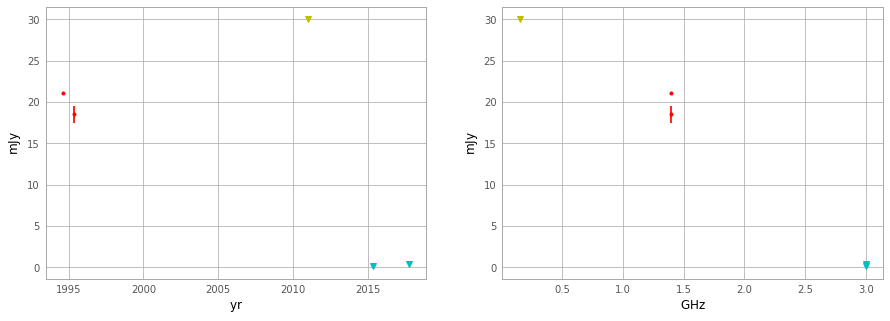

In [6]:
with quantity_support():
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.errorbar([t_first, t_nvss]*u.year, [s_first, s_nvss]*u.milliJansky, yerr=[es_first, es_nvss]*u.milliJansky, fmt='r.')  # 1.4 GHz
    plt.plot([t_vlass, t_farnes]*u.year, [s_vlass, s_farnes]*u.milliJansky, 'cv')  # 3 GHz
    plt.plot([t_tgss]*u.year, [s_tgss]*u.milliJansky, 'yv')  # 150 MHz
    plt.subplot(122)
    plt.errorbar([f_first, f_nvss]*u.GHz, [s_first, s_nvss]*u.milliJansky, yerr=[es_first, es_nvss]*u.milliJansky, fmt='r.')  # 1.4 GHz
    plt.plot([f_vlass, f_farnes]*u.GHz, [s_vlass, s_farnes]*u.milliJansky, 'cv')  # 3 GHz
    plt.plot([f_tgss]*u.GHz, [s_tgss]*u.milliJansky, 'yv')  # 150 MHz

It's gone!

Other potential data sets to analyze:
* VLA AS0249 (L-band, A-config, 86-Apr-11) -- earlier L-band really important
* VLA AB0573 (L-band, CD-config, 91-Feb-08) -- earlier L-band really important
* VLA AB0806 (L-band, A-config, 96-Nov-14) -- late L-band
* VLA AL0485 (L-band, D-config, 99-Apr-13) -- late L-band
* VLA 12B-361 (L-band, A-config, 12-Dec-24) -- late L-band


## Radio supernova modeling

#### It is really luminous

In [7]:
co = cosmo.Planck15
d_lum = co.luminosity_distance(0.01957)
lum_minL = (s_first*1e-3)*1e-23 * 4*np.pi*d_lum.to_value(u.cm)**2
nulnu_min = lum_minL*f_first*1e9

In [8]:
print("*Minimum* radio luminosity: L={0} erg/s/Hz, nuLnu = {1} erg/s".format(lum_minL, nulnu_min))

*Minimum* radio luminosity: L=1.9507261551882188e+29 erg/s/Hz, nuLnu = 2.7310166172635063e+38 erg/s


In [9]:
def lc_fong(fp, t0, tdec, p=2.4):
    """ Lightcurve as in Fong et al (2018).
    Short GRB from NS-NS merger.
    https://arxiv.org/pdf/1607.00416.pdf
    """

    timearr = np.linspace(t_first, t_vlass, 100)
    fluxarr = np.zeros_like(timearr)

    # early evolution
    t1 = np.where(timearr-t0 < tdec)
    fluxarr[t1] = fp*((timearr[t1]-t0)/tdec)**3

    # late evolution
    t2 = np.where(timearr-t0 >= tdec)
    fluxarr[t2] = fp*((timearr[t2]-t0)/tdec)**-((15*p-21)/10)

    return timearr, fluxarr

In [10]:
def lc_margalit(D, nu, t0):
    """ Decaying lightcurve of magnetar powered supernova
    Referenced to FRB 121102 persistent source.
    D in Gpc, nu in GHz, t in yrs.
    assumes alpha=0 and vej=1e9, t_repeater = 30
    """
    
    timearr = np.linspace(t_first, t_vlass, 100)
    fluxarr = np.zeros_like(timearr)

    fluxarr = 240e-6 * D**(-2) * (nu/10)**(1/3) * (30/(timearr-t0))
    
    return timearr, fluxarr

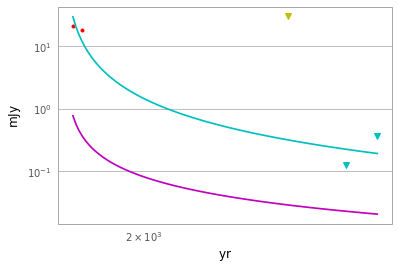

In [11]:
# TODO: add spectral index correction

with quantity_support():
    plt.plot([t_first, t_nvss]*u.year, [s_first, s_nvss]*u.milliJansky, 'r.')
    plt.plot([t_vlass, t_farnes]*u.year, [s_vlass, s_farnes]*u.milliJansky, 'cv')

    times, fluxes = lc_fong(s_first*3, 1993.8, 0.5)
    plt.plot(times*u.year, fluxes*u.millijansky, 'c')
    times, fluxes = lc_margalit(d_lum.value/1e3, 1.4, 1994)
    plt.plot(times*u.year, fluxes*u.millijansky, 'm')
    plt.plot([t_tgss]*u.year, [s_tgss]*u.milliJansky, 'yv')
    plt.loglog()

Compare to Kamble et al (2014), on VLASS discovery of radio supernovae.
<img src="kamble.png" width="800">

Compare to Metzger et al (2018), on rates and lightcurves or radio transients.
<img src="metzger.png" width="800">

#### Luminosity and time scale consistent with GRB or even more energetic phenomenon!

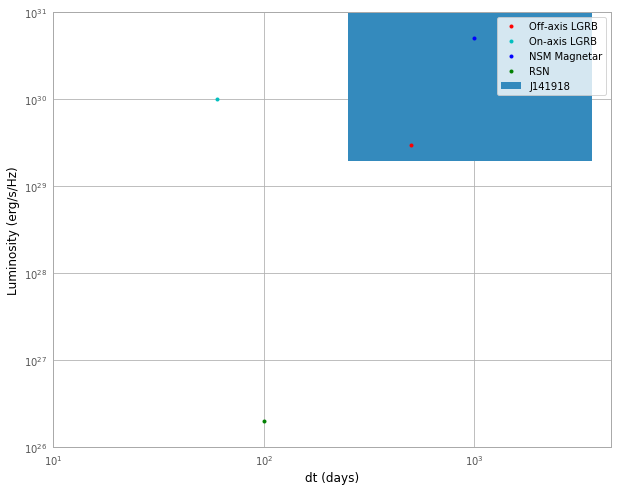

In [12]:
# playing with Metzger et al (2015) plot

fig = plt.figure(figsize=(10,8))
plt.plot(500, 3e29, 'r.', label="Off-axis LGRB")
plt.plot(60, 1e30, 'c.', label="On-axis LGRB")
plt.plot(1000, 5e30, 'b.', label="NSM Magnetar")
plt.plot(100, 2e26, 'g.', label="RSN")
plt.fill_between(np.arange((t_nvss-t_first)*365.24, 3650, 10), lum_minL, 1e31, label="J141918")
plt.xlim(10, 4500)
plt.ylim(1e26, 1e31)
plt.loglog()
plt.xlabel("dt (days)")
plt.ylabel("Luminosity (erg/s/Hz)")
plt.legend()

## Next steps

* Analyze more VLA data to fill in lightcurve (esp at L band)
* Lightcurve modeling with spectral dependence
* ~~Include models for other kinds of afterglows (or more general model?)~~
* ~~Constrain L vs dt space to classify on Metzger plot~~
* Consider rates: Ofek catalog is complete over what volume? (0.1*L_FRB121102 limit and SDSS limit)

## References

* Brunthaler et al radio discovery of SN in M82: https://arxiv.org/pdf/0904.2388.pdf
* Metzger, Williams and Berger on rates and lightcurves of radio transients: https://arxiv.org/pdf/1502.01350.pdf
* Fong et al on sGRB radio afterglows: https://arxiv.org/pdf/1502.01350.pdf
* Margalit et al on magnetar unification: https://arxiv.org/pdf/1806.05690.pdf